Z0: 0.000000
Z1: 0.999938
Z2: 0.999938
Z3: -0.000000
Z4: 0.999548
Z5: 0.999548
Z6: -0.000000
Z7: 0.996268
Z8: 0.996268
Z9: 0.000000
Z10: 0.969725
Z11: 0.969725
Z12: -0.000000
Z13: 0.753898
Z14: 0.753898
Z15: 0.000000


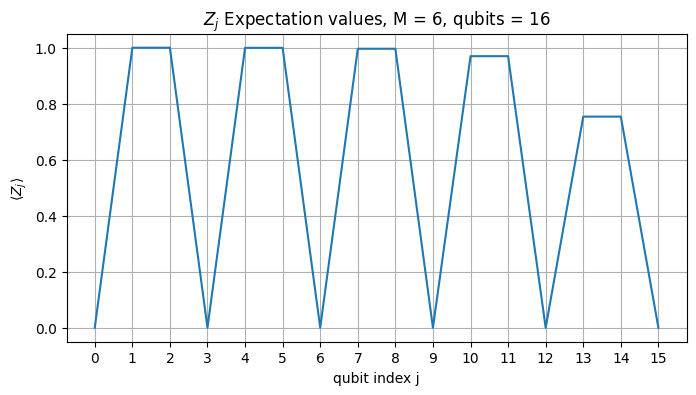

In [2]:
# Fractional Quantum Hall States - expectation values without building dense operators
import numpy as np
import matplotlib.pyplot as plt
from qiskit import QuantumCircuit
from qiskit.quantum_info import Statevector,Pauli

np.set_printoptions(suppress=True, formatter={'all': lambda x: "{:.4g}".format(x)})

############################
# -- Initialization     -- #
############################
t = float(input("input t parameter (real): "))
M = int(input("input # of electrons M (integer): "))  
qubits = 3*M - 2
qc = QuantumCircuit(qubits)


############################
# -- Building the FQH   -- #
############################
def stage0(circuit, qubits):
    i = 0
    while i < qubits:
        circuit.h(i)
        i += 3
    return circuit

def angles(list_phi,k,t):
    if k>M-2:
        return list_phi
    elif k==0:
        list_phi.append(np.arctan(-t))
        angles(list_phi,k+1,t)
    else:
        list_phi.append(np.arctan(-t*np.cos(list_phi[k-1])))
        angles(list_phi, k+1,t)

def stage1(circuit, qubits, lst):
    index = 0
    for i in range(qubits):
        if i % 3 == 1:
            if i == 1:
                circuit.ry(-2 * lst[index], i)
                index += 1
            else:
                circuit.cry(-2 * lst[index], i - 3, i)
                index += 1
    return circuit

def stage2a(circuit, qubits):
    for index in range(qubits):
        if index % 3 == 1:
            circuit.cx(index, index + 1)

def stage2b(circuit, qubits):
    for index in range(1, qubits):
        if index % 3 == 1:
            circuit.rz(np.pi, index)
        if index % 3 == 0:
            circuit.cx(index - 1, index)

def stage2c(circuit, qubits):
    for index in range(qubits):
        if index % 3 == 1:
            circuit.cx(index, index - 1)
        if (index % 3 == 0) and (index != 0):
            circuit.rz(np.pi, index - 1)

#############################
# -- Expectation Values  -- #
#############################
def get_Z(circuit,qubits):
# I'm trying to comment out this section as best i can 
# # so I can attempt to break down what the heck is going on, for my readers/future self.
    
    sv = Statevector.from_instruction(circuit)# constructs a statevector from evolution of circuit w/ initial state |0...0>
    ev_list = [] 
    for k in range(qubits): # for each qubit, calculate it's corresponding < Z_j > and append to a list.
        # Pauli string: Z on qubit k, I on all others
        pauli_str = ['I'] * qubits
        pauli_str[k] = 'Z'
        pauli_op = Pauli(''.join(pauli_str)) 
        
        # Computes expectation value
        ev = sv.expectation_value(pauli_op) # calculates the expectation value for the jth qubit
        ev_list.append(np.real(ev))  # convert to float if complex with zero imaginary part
    return ev_list

################################
# -- Calling every function -- #
################################
list_phi = []
angles(list_phi, 0, t)
list_phi.reverse()

stage0(qc, qubits)
qc.barrier()
stage1(qc, qubits, list_phi)
qc.barrier()
stage2a(qc, qubits)
stage2b(qc, qubits)
stage2c(qc, qubits)
evs = get_Z(qc,qubits)


for k, ev in enumerate(evs):
    print(f"Z{k}: {ev:.6f}")

# Here, x is just a scalar (number of qubits), and plots on the x_axis a range from q0 to 'qx'
plt.figure(figsize=(8, 4))
plt.plot(range(qubits),evs)
plt.xticks(range(qubits))
plt.xlabel('qubit index j')
plt.ylabel(r'$\langle Z_j \rangle$')
plt.title(f'$Z_{"j"}$ Expectation values, M = {M}, qubits = {qubits}')
plt.grid(True)
plt.show()
